# Automated ML

TODO: Import Dependencies. In the cell below, import all the dependencies that you will need to complete the project.

## Dataset

### Overview
TODO: In this markdown cell, give an overview of the dataset you are using. Also mention the task you will be performing.


TODO: Get data. In the cell below, write code to access the data you will be using in this project. Remember that the dataset needs to be external.

In [1]:
from azureml.core import Workspace, Experiment
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.widgets import RunDetails
import os
import joblib

from azureml.train.automl import AutoMLConfig
from pprint import pprint # Used in printing automl model parameters
from azureml.core import Model # Used to get model information
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace

ws = Workspace.from_config()

experiment_name = 'Cervical-Cancer-Predict'
#project_folder = './Capstone-project'

experiment=Experiment(ws, experiment_name)

In [2]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

compute_cluster_name = 'cluster-capstone'

try:
    compute_target = ComputeTarget(workspace=ws, name = compute_cluster_name)
    print('Found the compute cluster')

except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size="STANDARD_D3_V2", max_nodes=4)
    compute_target = ComputeTarget.create(ws, compute_cluster_name, compute_config)
    compute_target.wait_for_completion(show_output=True)

Creating
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


Create an environment : 

%%writefile conda_dependencies.yml

dependencies:
- python=3.6.9
- scikit-learn==0.24.1
- pip:
  - xgboost==0.90
  - azureml-defaults

Register the environment to the workspace :

from azureml.core import Environment

Automlenv = Environment.from_conda_specification(name = 'Automlenv', file_path = './conda_dependencies.yml')

Automlenv.register(workspace=ws)
Automlenv.python.conda_dependencies.serialize_to_string()

In [11]:
# Try to load the dataset from the Workspace. Otherwise, create it from the file
# NOTE: update the key to match the dataset name
from azureml.core.dataset import Dataset
from azureml.data.dataset_factory import TabularDatasetFactory
found = False
key = 'Cervical Cancer risk'
description_text = 'Cervical Cancer Behavior Risk Data Set'

if key in ws.datasets.keys(): 
        found = True
        dataset = ws.datasets[key] 

if not found:
        # Create AML Dataset and register it into Workspace
        example_data = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00537/sobar-72.csv'
        dataset = TabularDatasetFactory.from_delimited_files(example_data)       
        #Register Dataset in Workspace
        dataset = dataset.register(workspace=ws,
                                   name=key,
                                   description=description_text)


df = dataset.to_pandas_dataframe()
df.describe()

,behavior_sexualRisk,behavior_eating,behavior_personalHygine,intention_aggregation,intention_commitment,attitude_consistency,attitude_spontaneity,norm_significantPerson,norm_fulfillment,perception_vulnerability,perception_severity,motivation_strength,motivation_willingness,socialSupport_emotionality,socialSupport_appreciation,socialSupport_instrumental,empowerment_knowledge,empowerment_abilities,empowerment_desires,ca_cervix
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,9.666667,12.791667,11.083333,7.902778,13.347222,7.180556,8.611111,3.125000,8.486111,8.513889,5.388889,12.652778,9.694444,8.097222,6.166667,10.375000,10.541667,9.319444,10.277778,0.291667
std,1.186782,2.361293,3.033847,2.738148,2.374511,1.522844,1.515698,1.845722,4.907577,4.275686,3.400727,3.207209,4.130406,4.243171,2.897303,4.316485,4.366768,4.181874,4.482273,0.457719
min,2.000000,3.000000,3.000000,2.000000,6.000000,2.000000,4.000000,1.000000,3.000000,3.000000,2.000000,3.000000,3.000000,3.000000,2.000000,3.000000,3.000000,3.000000,3.000000,0.000000
25%,10.000000,11.000000,9.000000,6.000000,11.000000,6.000000,8.000000,1.000000,3.000000,5.000000,2.000000,11.000000,7.000000,3.000000,3.750000,6.750000,7.000000,5.000000,6.750000,0.000000
50%,10.000000,13.000000,11.000000,10.000000,15.000000,7.000000,9.000000,3.000000,7.000000,8.000000,4.000000,14.000000,11.000000,9.000000,6.500000,12.000000,12.000000,10.000000,11.000000,0.000000
75%,10.000000,15.000000,14.000000,10.000000,15.000000,8.000000,10.000000,5.000000,14.000000,13.000000,9.000000,15.000000,13.000000,11.250000,9.000000,14.250000,15.000000,13.000000,15.000000,1.000000
max,10.000000,15.000000,15.000000,10.000000,15.000000,10.000000,10.000000,5.000000,15.000000,15.000000,10.000000,15.000000,15.000000,15.000000,10.000000,15.000000,15.000000,15.000000,15.000000,1.000000


In [12]:
dataset.take(5).to_pandas_dataframe()

,behavior_sexualRisk,behavior_eating,behavior_personalHygine,intention_aggregation,intention_commitment,attitude_consistency,attitude_spontaneity,norm_significantPerson,norm_fulfillment,perception_vulnerability,perception_severity,motivation_strength,motivation_willingness,socialSupport_emotionality,socialSupport_appreciation,socialSupport_instrumental,empowerment_knowledge,empowerment_abilities,empowerment_desires,ca_cervix
0,10,13,12,4,7,9,10,1,8,7,3,14,8,5,7,12,12,11,8,1
1,10,11,11,10,14,7,7,5,5,4,2,15,13,7,6,5,5,4,4,1
2,10,15,3,2,14,8,10,1,4,7,2,7,3,3,6,11,3,3,15,1
3,10,11,10,10,15,7,7,1,5,4,2,15,13,7,4,4,4,4,4,1
4,8,11,7,8,10,7,8,1,5,3,2,15,5,3,6,12,5,4,7,1


## AutoML Configuration

TODO: Explain why you chose the automl settings and cofiguration you used below.

In [13]:
from azureml.train.automl import AutoMLConfig
# TODO: Put your automl settings here
automl_settings = {
    "experiment_timeout_minutes": 20,
    "max_concurrent_iterations": 4,
    "primary_metric" : 'accuracy'
}

# TODO: Put your automl config here
automl_config = AutoMLConfig(
        task='classification',
        training_data=dataset,
        label_column_name='ca_cervix',
        n_cross_validations=5,
        **automl_settings
        )

In [14]:
# TODO: Submit your experiment
remote_run = experiment.submit(automl_config, show_output=True)

No run_configuration provided, running on local with default configuration
Running on local machine
Parent Run ID: AutoML_08564e6b-b5ae-43f2-8279-72b59211afff

Current status: DatasetEvaluation. Gathering dataset statistics.
Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetFeaturization. Beginning to fit featurizers and featurize the dataset.
Current status: DatasetFeaturizationCompleted. Completed fit featurizers and featurizing the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Class balancing detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and all classes are balanced in your training data.
              Learn more about imbalanced data: https://aka.ms/AutomatedMLImbalancedData

**************************************************

## Run Details

OPTIONAL: Write about the different models trained and their performance. Why do you think some models did better than others?

TODO: In the cell below, use the `RunDetails` widget to show the different experiments.

In [15]:
from azureml.widgets import RunDetails

RunDetails(remote_run).show()
#remote_run.wait_for_completion(show_output=True)

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

## Best Model

TODO: In the cell below, get the best model from the automl experiments and display all the properties of the model.



In [17]:
# Get best run and model
best_run, fitted_model = remote_run.get_output()

# Print the best run
print(best_run)

# Get all metrics of the best run
best_run_metrics = best_run.get_metrics()

# Print all metrics of the best run
for metric_name in best_run_metrics:
    metric = best_run_metrics[metric_name]
    print(metric_name, metric)

Run(Experiment: Cervical-Cancer-Predict,
Id: AutoML_08564e6b-b5ae-43f2-8279-72b59211afff_44,
Type: None,
Status: Completed)
f1_score_weighted 0.9173544973544974
precision_score_micro 0.9180952380952381
recall_score_weighted 0.9180952380952381
f1_score_micro 0.9180952380952381
f1_score_macro 0.8797979797979798
average_precision_score_macro 0.9428224296446699
AUC_weighted 0.9480519480519479
precision_score_weighted 0.9234285714285715
average_precision_score_weighted 0.9658592518592519
weighted_accuracy 0.934404509800156
log_loss 0.24165389674909057
accuracy 0.9180952380952381
recall_score_macro 0.879004329004329
balanced_accuracy 0.879004329004329
AUC_macro 0.9480519480519479
average_precision_score_micro 0.9581682864615194
recall_score_micro 0.9180952380952381
AUC_micro 0.9557551020408163
norm_macro_recall 0.758008658008658
precision_score_macro 0.8875757575757575
matthews_correlation 0.7663373043552061
accuracy_table aml://artifactId/ExperimentRun/dcid.AutoML_08564e6b-b5ae-43f2-8279-72

In [18]:
# Print detailed parameters of the fitted model
def print_model(model, prefix=""):
    for step in model.steps:
        print(prefix + step[0])
        if hasattr(step[1], 'estimators') and hasattr(step[1], 'weights'):
            pprint({'estimators': list(
                e[0] for e in step[1].estimators), 'weights': step[1].weights})
            print()
            for estimator in step[1].estimators:
                print_model(estimator[1], estimator[0] + ' - ')
        else:
            pprint(step[1].get_params())
            print()

print_model(fitted_model)

datatransformer
{'enable_dnn': None,
 'enable_feature_sweeping': None,
 'feature_sweeping_config': None,
 'feature_sweeping_timeout': None,
 'featurization_config': None,
 'force_text_dnn': None,
 'is_cross_validation': None,
 'is_onnx_compatible': None,
 'logger': None,
 'observer': None,
 'task': None,
 'working_dir': None}

prefittedsoftvotingclassifier
{'estimators': ['24', '40', '19', '11', '30'],
 'weights': [0.16666666666666666,
             0.3333333333333333,
             0.16666666666666666,
             0.16666666666666666,
             0.16666666666666666]}

24 - minmaxscaler
{'copy': True, 'feature_range': (0, 1)}

24 - logisticregression
{'C': 494.1713361323828,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'saga',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

40 - pca
{'copy': True,
 'iterated_powe

In [20]:
#TODO: Save the best model
CancerModel = best_run.register_model(model_path='outputs/model.pkl', model_name='cancer_Model_automl',
                        tags={'Training context':'Auto ML'},
                        properties={'Accuracy': best_run_metrics['accuracy']})

print(CancerModel)

Model(workspace=Workspace.create(name='udacity-projects', subscription_id='08429d2c-c480-438d-b360-41b472ce37a7', resource_group='ml'), name=cancer_Model_automl, id=cancer_Model_automl:3, version=3, tags={'Training context': 'Auto ML'}, properties={'Accuracy': '0.9180952380952381'})


In [21]:
# List registered models to verify if model has been saved
for model in CancerModel.list(ws):
    print(model.name, 'version:', model.version)
    for tag_name in model.tags:
        tag = model.tags[tag_name]
        print ('\t',tag_name, ':', tag)
    for prop_name in model.properties:
        prop = model.properties[prop_name]
        print ('\t',prop_name, ':', prop)
    print('\n')


cancer_Model_automl version: 3
	 Training context : Auto ML
	 Accuracy : 0.9180952380952381




In [22]:
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load Test Cancer Dataset
X = df.drop(['ca_cervix'], axis=1)
y = df['ca_cervix']
#Split the Dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=44)

In [23]:
#Predictions :
y_pred = fitted_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Model Metrics Vizualisation : 

In [24]:

# Confusion matrix
pd.DataFrame(cm).style.background_gradient(cmap='Blues', low=0, high=0.9)


,0,1
0,17,0
1,0,7


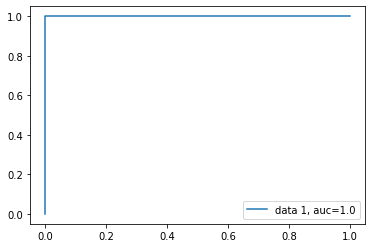

In [25]:
# AUC Curve
y_pred_proba = fitted_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

## Model Deployment

Remember you have to deploy only one of the two models you trained.. Perform the steps in the rest of this notebook only if you wish to deploy this model.

TODO: In the cell below, register the model, create an inference config and deploy the model as a web service.

In [26]:
# Download scoring file 
best_run.download_file('outputs/scoring_file_v_1_0_0.py', 'score.py')

# Download environment file
from azureml.core.environment import Environment
best_run.download_file('outputs/conda_env_v_1_0_0.yml', 'envFile.yml')
env = Environment.from_conda_specification(name='cancer-environment', file_path='envFile.yml')


In [27]:

from azureml.core.model import InferenceConfig

inference_config = InferenceConfig(entry_script='score.py',
                                    environment=env)

# deploy
from azureml.core.webservice import AciWebservice

deployment_config = AciWebservice.deploy_configuration(cpu_cores = 1, memory_gb = 1)
service = Model.deploy(ws, "myservice", [CancerModel], inference_config, deployment_config)
service.wait_for_deployment(show_output = True)

print(service.state)
print(service.scoring_uri)
print(service.swagger_uri)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running........................................................
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy
http://bad17886-8048-42dc-a277-819ef8c7e391.eastus2.azurecontainer.io/score
http://bad17886-8048-42dc-a277-819ef8c7e391.eastus2.azurecontainer.io/swagger.json


In [23]:
import json

#Import test data
test_df = df.sample(5) # data is the pandas dataframe of the original data
label_df = test_df.pop('ca_cervix')

test_sample = json.dumps({'data': test_df.to_dict(orient='records')})

print(test_sample)

{"data": [{"behavior_sexualRisk": 10, "behavior_eating": 13, "behavior_personalHygine": 15, "intention_aggregation": 10, "intention_commitment": 15, "attitude_consistency": 8, "attitude_spontaneity": 10, "norm_significantPerson": 5, "norm_fulfillment": 14, "perception_vulnerability": 6, "perception_severity": 8, "motivation_strength": 13, "motivation_willingness": 7, "socialSupport_emotionality": 3, "socialSupport_appreciation": 4, "socialSupport_instrumental": 3, "empowerment_knowledge": 3, "empowerment_abilities": 6, "empowerment_desires": 3}, {"behavior_sexualRisk": 10, "behavior_eating": 13, "behavior_personalHygine": 15, "intention_aggregation": 8, "intention_commitment": 13, "attitude_consistency": 7, "attitude_spontaneity": 8, "norm_significantPerson": 3, "norm_fulfillment": 5, "perception_vulnerability": 9, "perception_severity": 2, "motivation_strength": 13, "motivation_willingness": 11, "socialSupport_emotionality": 12, "socialSupport_appreciation": 9, "socialSupport_instrume

### Consume the endpoint with request-response

In [25]:
import requests # Used for http post request

# Set the content type
headers = {'Content-type': 'application/json'}


response = requests.post(service.scoring_uri, test_sample, headers=headers)

In [26]:
# Print results from the inference
print(response.text)

"{\"result\": [0, 0, 0, 0, 0]}"


In [27]:
# Print original labels
print(label_df)

63    0
26    0
71    0
65    0
23    0
Name: ca_cervix, dtype: int64


In [28]:
print(service.get_logs())

2021-03-25T16:48:00,237710800+00:00 - rsyslog/run 
2021-03-25T16:48:00,244662700+00:00 - gunicorn/run 
2021-03-25T16:48:00,260233200+00:00 - nginx/run 
2021-03-25T16:48:00,260981000+00:00 - iot-server/run 
/usr/sbin/nginx: /azureml-envs/azureml_6f3791fe7434448b4ebe2b0fd691d644/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_6f3791fe7434448b4ebe2b0fd691d644/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_6f3791fe7434448b4ebe2b0fd691d644/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_6f3791fe7434448b4ebe2b0fd691d644/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_6f3791fe7434448b4ebe2b0fd691d644/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)
rsyslogd

In [29]:
service.delete()